# Road Graphing

### GPU Configurations

In [1]:
import os                       # Operating system-related functions (file, directory operations)
import sys                      # Provides access to system-specific parameters and functions
import shutil                   # Provides high-level file operations (copying, moving, etc.)
import platform                 # Provides functions and information about the operating system and hardware

import numpy as np              # NumPy library for numerical operations & array manipulation
import pickle                   # for object serialization & deserialization
import random                   # generates random numbers

import cv2                      # computer vision & image processing
import tensorflow as tf         # deep learning framework
import keras                    # training & evaluating deep learning models

from skimage.io import imread   # reading images
from skimage.io import imshow   # displaying images
from tqdm import tqdm           # creating progress bars in loops
from typing import List         # type hinting
from typing import Tuple         # type hinting
import matplotlib.pyplot as plt # creating plots & visualizations

In [2]:
# Check Operating System & Platform
print('Operating System:', platform.system(), platform.release())
print('Python Platform:', platform.platform())

# Check Python Environment & Version
print('Python Environment:', sys.executable)
print('Python Version:', sys.version)
print()

# Print library versions
print('NumPy Version:', np.__version__)
print('OpenCV Version:', cv2.__version__)
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print()

# Check if any GPU is available
print('GPU is Available:', len(tf.config.list_physical_devices('GPU')) > 0)
print('Number of GPUs Available:', len(tf.config.list_physical_devices('GPU')))

Operating System: Darwin 22.6.0
Python Platform: macOS-13.6-arm64-arm-64bit
Python Environment: /Users/xiongyun/miniconda3/envs/tensorflow/bin/python
Python Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]

NumPy Version: 1.24.3
OpenCV Version: 4.8.0
TensorFlow Version: 2.13.0
Keras Version: 2.13.1

GPU is Available: True
Number of GPUs Available: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-03 18:27:02.658635: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-03 18:27:02.658653: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-03 18:27:02.658658: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-03 18:27:02.658717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-03 18:27:02.658929: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Create Directories

The directory containing the dataset used in this notebook is  **'../datasets/deepglobe/train'**. Create directories from the dataset's directory for the training, validation, and test data (if they do not exist). Additionally, create a directory to store pickled Numpy arrays for later usage.

In [4]:
# Directory containing dataset
dataset_dir = '../datasets/deepglobe/train'

# Directories containing 128x128 tiles of  images & masks
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
pickel_dir = os.path.join(dataset_dir, 'pickle')

# Directories containing original 1024x1024 images & masks
orig_train_dir      = os.path.join(dataset_dir, 'original_train')
orig_validation_dir = os.path.join(dataset_dir, 'original_validation')
orig_test_dir       = os.path.join(dataset_dir, 'original_test')
orig_pickel_dir     = os.path.join(dataset_dir, 'original_pickle')

In [5]:
import networkx as nx                       # graph-based data structures & algorithms
from skimage.morphology import skeletonize  # image skeletonization
from skimage.measure import label           # connected component labeling
from skimage.draw import line               # drawing straight lines in images

from PIL import Image                       # image manipulation & loading

## Plot Image Grid

* plot_image_grid(image_dir: str, image_name: str, rows: int = 4, cols: int = 4) -> None:


In [6]:
# List all satellite images in the dataset directory
mask_extensions = ['.png']
mask_filenames = [filename for filename in os.listdir(train_dir) if os.path.splitext(filename)[-1] in mask_extensions]

# Set random seed: 0
random.seed(0)

# Shuffle the files randomly
random.shuffle(mask_filenames)

mask_filenames[0]

'492923_mask_tile_0.png'

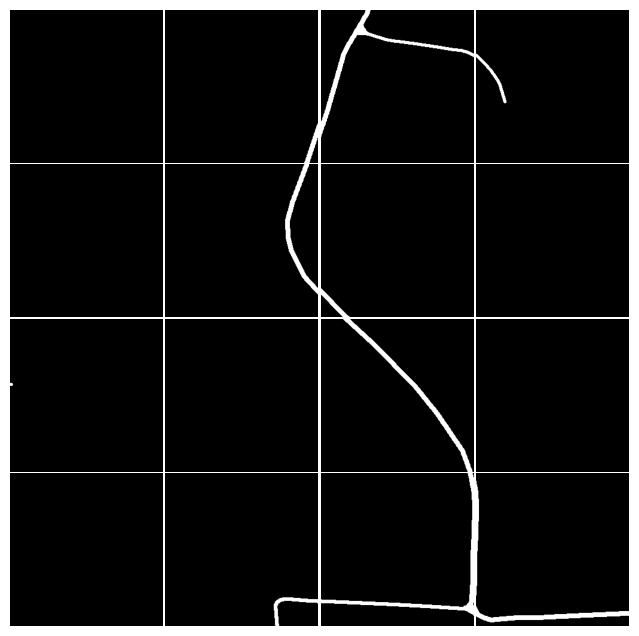

In [7]:
def plot_image_grid(image_dir: str, image_name: str, rows: int = 4, cols: int = 4) -> None:
    '''
    Plot a grid of images from a directory based on a specified image name format.

    Args:
        image_dir (str): The directory where image tiles are located.
        image_name (str): The base image name without index or extension (e.g., '492923_mask_tile_0.png').
        rows (int, optional): Number of rows in the grid. Defaults to 4.
        cols (int, optional): Number of columns in the grid. Defaults to 4.

    Returns:
        None
    '''
    # Create a subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

    # Remove trailing '0.png' from the displayed label
    image_name = image_name.rstrip('0.png')

    # Iterate through the grid
    for i in range(rows):
        for j in range(cols):
            # Construct the filename for the current tile
            index = i * cols + j
            filename = f'{image_name}{index}.png'
            file_path = os.path.join(image_dir, filename)

            # Load and plot the image
            if os.path.exists(file_path):
                image = Image.open(file_path)
                axes[i, j].imshow(image, cmap='gray')
                axes[i, j].axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Display the combined image
    plt.show()

# Example usage:
plot_image_grid(train_dir, '492923_mask_tile_0.png')

In [8]:
# Load RGB Images
#with open(os.path.join(pickel_dir, 'X_train_128.pkl'), 'rb') as f:
#    X_train = pickle.load(f)

# Load Masks (ground truth)
#with open(os.path.join(pickel_dir, 'y_train_128.pkl'), 'rb') as f:
#    y_train = pickle.load(f)

## Graph Function

In [9]:
def create_road_network_graph(road_network: np.ndarray, distance_threshold: float = 1.5) -> nx.Graph:
    '''
    Create a road network graph from an image.

    Args:
        road_network (np.ndarray): The image representing the road network.
        distance_threshold (float): Maximum distance (in pixels) for nodes to be considered neighbors.

    Returns:
        nx.Graph: The road network graph.
    '''

    # Binarize greyscale masks to black & white, set threshold = 128
    road_network = (road_network > 128)

    # Convert to skeleton to extract centerline of roads
    skeleton = skeletonize(road_network)
    
    # Create a NetworkX graph
    graph = nx.Graph()

    # Iterate over skeleton pixels and add them as nodes
    for r in range(0, skeleton.shape[0], 1):
        for c in range(0, skeleton.shape[1], 1):
            if skeleton[r, c] == 1 or skeleton[r, c] == True:
                graph.add_node((r, c))

    # Iterate over nodes and add edges
    for node1 in graph.nodes():
        for node2 in graph.nodes():
            if node1 != node2:
                r1, c1 = node1
                r2, c2 = node2
                distance = np.sqrt((r2 - r1) ** 2 + (c2 - c1) ** 2)
                if distance <= distance_threshold:
                    graph.add_edge(node1, node2)

    return graph

In [10]:
%%script echo angle
def calculate_angle(node1: Tuple[int, int], node0: Tuple[int, int], node2: Tuple[int, int]) -> float:
    '''
    Calculate the angle between three nodes.

    Args:
        node1 (Tuple[int, int]): Coordinates of the first node   (x, y).
        node0 (Tuple[int, int]): Coordinates of the central node (x, y).
        node2 (Tuple[int, int]): Coordinates of the second node  (x, y).

    Returns:
        float: The angle in degrees between the vectors connecting the three nodes.
    '''
    r0, c0 = node0
    r1, c1 = node1
    r2, c2 = node2
    vector1 = np.array([r1 - r0, c1 - c0])
    vector2 = np.array([r2 - r0, c2 - c0])
    cos_theta = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    angle = np.arccos(cos_theta) * 180 / np.pi
    return angle

angle


In [11]:
def classify_road_segments(graph: nx.Graph) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    '''
    Classify nodes in a road network graph into terminal nodes, intersection nodes, and line segments.

    Args:
        graph (nx.Graph): The road network graph.

    Returns:
        Tuple[List[Tuple[int, int]], List[Tuple[int, int]], List[List[Tuple[int, int]]]]:
            - terminal_nodes: List of terminal node coordinates (x, y).
            - intersection_nodes: List of intersection node coordinates (x, y).
    '''

    terminal_nodes = []
    intersection_nodes = []

    # Post-Processing:
    nodes_to_remove = set()  # Use a set to store nodes to remove
    edges_to_add = []        # List to store edges to add

    intermediate_nodes = set()
    nodes = list(graph.nodes())

    for node in nodes:
        neighbors = list(graph.neighbors(node))

        if len(neighbors) == 1:
            terminal_nodes.append(node)

        elif len(neighbors) > 2:
            intersection_nodes.append(node)

    return terminal_nodes, intersection_nodes

## Plotting Road Networks

In [12]:
def plot_road_network_overlay(
    image, 
    graph: nx.Graph, 
    terminal_nodes: List[Tuple[int, int]], 
    intersection_nodes: List[Tuple[int, int]], 
    figsize: Tuple[int, int] = (8, 8), 
    node_size: int = 50
) -> None:
    '''
    Plot the road network graph overlay on the provided mask image with terminal and intersection nodes highlighted.

    Args:
        image: The image to overlay the graph on.
        graph (nx.Graph): The road network graph.
        terminal_nodes (list): List of terminal node coordinates (x, y).
        intersection_nodes (list): List of intersection node coordinates (x, y).
        figsize (tuple): Figure size (width, height). Defaults to (8, 8).
        node_size (int): Node size for plotting. Defaults to 50.
    
    Returns:
        None
    '''
    # Plot the original road mask
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')

    # Define positions for graph nodes for plotting (swapping x and y coordinates)
    pos = {node: (node[1], node[0]) for node in graph.nodes()}

    # Overlay the graph on the mask
    nx.draw(graph, pos, node_size=node_size, node_color='#FFFF00', edge_color='#FFFF00', alpha=0.9)

    # Plot terminal nodes in green and intersection nodes in red
    nx.draw_networkx_nodes(graph, pos, nodelist=terminal_nodes, node_color='red', node_size=2*node_size)
    nx.draw_networkx_nodes(graph, pos, nodelist=intersection_nodes, node_color='#39FF14', node_size=2*node_size)

    plt.title('Overlay of Road Network Graph on Image')
    plt.show()


In [13]:
def plot_road_network_graph(
    graph: nx.Graph, 
    terminal_nodes: List[Tuple[int, int]], 
    intersection_nodes: List[Tuple[int, int]], 
    figsize: Tuple[int, int] = (8, 8), 
    node_size: int = 50
) -> None:
    '''
    Plot the road network graph with terminal and intersection nodes highlighted.

    Args:
        graph (nx.Graph): The road network graph.
        terminal_nodes (list): List of terminal node coordinates (x, y).
        intersection_nodes (list): List of intersection node coordinates (x, y).
        figsize (tuple): Figure size (width, height). Defaults to (8, 8).
        node_size (int): Node size for plotting. Defaults to 50.

    Returns:
        None
    '''
    # Create a plot
    plt.figure(figsize=figsize)

    # Define positions for graph nodes for plotting (swapping x and y coordinates)
    pos = {node: (node[1], node[0]) for node in graph.nodes()}

    # Plot the graph
    nx.draw(graph, pos, node_size=node_size, node_color='blue', edge_color='yellow', alpha=0.8)

    # Plot terminal nodes in green and intersection nodes in red
    nx.draw_networkx_nodes(graph, pos, nodelist=terminal_nodes, node_color='red', node_size=node_size)
    nx.draw_networkx_nodes(graph, pos, nodelist=intersection_nodes, node_color='#FAC898', node_size=node_size)

    plt.title('Road Network Graph')
    plt.show()

In [14]:
def distance(point1: Tuple[float, float], point2: Tuple[float, float]) -> float:
    '''
    Calculate Euclidean distance between two points represented as tuples (x, y).
    
    Args:
        point1 (Tuple[float, float]): First point as a tuple (x, y).
        point2 (Tuple[float, float]): Second point as a tuple (x, y).
    
    Returns:
        float: The Euclidean distance between the two points.
    '''
    point1 = np.array(point1)
    point2 = np.array(point2)
    distance = np.linalg.norm(point1 - point2)
    return round(distance)

def contracting_nodes(graph, degree_threshold=2, min_distance=30):
    '''
    Contract nodes in a graph based on a given threshold and minimum distance.

    Args:
        graph (nx.Graph): The input graph.
        degree_threshold (float): The threshold for node contraction.
        min_distance (float): Minimum distance from a contracted node.

    Returns:
        nx.Graph: The contracted graph.
    '''
    contracted_graph = graph.copy()
    nodes_to_not_contract = []

    # Continue contracting nodes until no node has a degree greater than the threshold
    while True:
        degrees = dict(contracted_graph.degree())

        # Find nodes to contract
        nodes_to_contract = [node for node, degree in degrees.items() if degree == degree_threshold and node not in nodes_to_not_contract]

        # if all nodes are spaced min_distance apart or there is enough contraction
        if not nodes_to_contract:
            break
        
        # Contract nodes unless nodes' distance > the minimum distance
        for node in nodes_to_contract:
            neighbors = list(contracted_graph.neighbors(node))
            if len(neighbors) == 2:
                u, v = neighbors
                
                # Check the distance between contracted node and its neighbors
                if distance(u, v) <= min_distance:
                    contracted_graph = nx.contracted_edge(contracted_graph, (u, node), self_loops=False)
                else:
                    nodes_to_not_contract.extend([node])

    return contracted_graph

## Post-Processing

## Testing

### Sample Mask

In [16]:
def save_road_network_overlay(
    image: np.ndarray, 
    save_dir: str,
    graph: nx.Graph, 
    node_size: int = 10,
    DPI: int = 100
) -> None:
    '''
    Plot the road network graph overlay on the provided mask image with terminal and intersection nodes highlighted.

    Args:
        image (np.ndarray): The image to overlay the graph on.
        save_dir (str): The directory to save the image.
        graph (nx.Graph): The road network graph.
        node_size (int): Node size for plotting. Defaults to 50.
        DPI (int): Dots per inches. Defaults to 143
    
    Returns:
        None
    '''
    WIDTH  = image.shape[1] / DPI
    HEIGHT = image.shape[0] / DPI
    
    # Create a figure with the same dimensions as the input image
    figsize = (WIDTH, HEIGHT)

    # Scale down for a reasonable figure size
    fig, ax = plt.subplots(figsize=figsize, dpi = 142)

    # Turn off axis
    ax.axis('off')
    ax.margins(x=0,y=0)
    
    # Plot the original road mask
    ax.imshow(image, cmap='gray')
    
    # Define positions for graph nodes for plotting
    pos = {node: (node[1], node[0]) for node in graph.nodes()}

    # Overlay the graph on the mask
    nx.draw(graph, pos, ax=ax, node_size=node_size, node_color='white', edge_color='white', alpha=0.9)

    # Save the figure with the same dimensions as the input image
    fig.savefig(save_dir, format='PNG')
    
    # open the original image
    # original_image = cv2.imread(save_dir)

    # remove original image
    # os.remove(save_dir)
    
    # Define the coordinates for cropping
    # x1, y1 = 235, 240               # top-left corner
    # x2, y2 = x1 + 1024, y1 + 1024   # bottom-right corner
    
    # Crop the image
    # cropped_image = original_image[y1:y2, x1:x2]
    
    # Save the cropped image
    # cv2.imwrite(save_dir, cropped_image)

In [17]:
%%script echo

# List all masks in the directory
mask_extensions = ['.png']
mask_filenames = [filename for filename in os.listdir(orig_train_dir) if os.path.splitext(filename)[-1] in mask_extensions]

black = np.zeros(shape=(1024, 1024))

random_mask = mask_filenames[10]
random_mask = '1945_mask.png'
random_mask = mask_filenames[111]
random_image = random_mask.replace('_mask.png', '_sat.jpg')

# read road network mask as greyscale
mask = cv2.imread(os.path.join(orig_train_dir, random_mask), 0)

graph = create_road_network_graph(mask)
graph = contracting_nodes(graph, min_distance=30)
terminal_nodes, intersection_nodes = classify_road_segments(graph)
save_road_network_overlay(black, 'asd.png', graph, node_size=5)



In [18]:
%%script echo
random_graph = random_mask.replace('_mask.png', '_graph.p')
with open(random_graph, 'wb') as file:
    pickle.dump(graph, file)

with open(random_graph, 'rb') as file:
    loaded_graph = pickle.load(file)

plot_road_network_overlay(black, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=5)

In [19]:
%%script echo

im_file = 'asd.png'
random_mask = mask_filenames[111]
random_image = random_mask.replace('_mask.png', '_sat.jpg')

image = cv2.imread(os.path.join(orig_train_dir,random_image), 0)
plot_road_network_overlay(black, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=5)

In [20]:
%%script echo
graph = create_road_network_graph(mask)
terminal_nodes, intersection_nodes = classify_road_segments(graph)

print('Graph size before contraction:', len(graph.nodes()))
graph = contracting_nodes(graph, min_distance=30)
print('Graph size after contraction:' , len(graph.nodes()))

# Plot the Road Network Graph
#plot_road_network_graph(graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=50)

# Plot the Road Network Graph with Image Overlay
plot_road_network_overlay(mask, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=5)

In [21]:
%%script echo
black = np.zeros(shape=(1024, 1024))
plot_road_network_overlay(black, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=10)


checkpoint = '669884_mask.png'

index = mask_filenames.index(checkpoint)
print(mask_filenames[index-1])
print(mask_filenames[index+1])

mask_filenames = mask_filenames[index+1:]
mask_filenames[0]

In [22]:
black = np.zeros(shape=(1024, 1024))
mask_extensions = ['.png']
dir = orig_train_dir # repeat for orig_validation_dir and orig_test_dir

# List all masks in the train dataset directory
mask_filenames = [filename for filename in os.listdir(dir) if os.path.splitext(filename)[-1] in mask_extensions]


for filename in mask_filenames:

    # new gt_graph filename
    filename1= os.path.join(dir, filename.replace('mask', 'gt_graph'))

    # new graph filename
    filename2 = filename1.replace('gt_graph.png', 'graph.pkl')

    # check if file already exists
    if os.path.exists(filename2):
        continue
    
    # read road network mask as greyscale
    mask = cv2.imread(os.path.join(dir, filename), 0)
    # create road network graph
    graph = create_road_network_graph(mask)
    # classify road segments
    terminal_nodes, intersection_nodes = classify_road_segments(graph)
    # contract nodes in graph
    graph1 = contracting_nodes(graph, min_distance=20)
    
    # save road network overlay
    # save_road_network_overlay(black, filename, graph1, node_size=5)

    with open(filename2, 'wb') as file:
        pickle.dump(graph1, file)

print('Done with Training Data')

Done with Training Data


In [23]:
black = np.zeros(shape=(1024, 1024))
mask_extensions = ['.png']
dir = orig_validation_dir

# List all masks in the train dataset directory
mask_filenames = [filename for filename in os.listdir(dir) if os.path.splitext(filename)[-1] in mask_extensions]


for filename in mask_filenames:

    # new gt_graph filename
    filename1= os.path.join(dir, filename.replace('mask', 'gt_graph'))

    # new graph filename
    filename2 = filename1.replace('gt_graph.png', 'graph.pkl')

    # check if file already exists
    if os.path.exists(filename2):
        continue
    
    # read road network mask as greyscale
    mask = cv2.imread(os.path.join(dir, filename), 0)
    # create road network graph
    graph = create_road_network_graph(mask)
    # classify road segments
    terminal_nodes, intersection_nodes = classify_road_segments(graph)
    # contract nodes in graph
    graph1 = contracting_nodes(graph, min_distance=20)
    
    # save road network overlay
    # save_road_network_overlay(black, filename, graph1, node_size=5)

    with open(filename2, 'wb') as file:
        pickle.dump(graph1, file)

print('Done with Validation Data')

Done with Validation Data


In [24]:
black = np.zeros(shape=(1024, 1024))
mask_extensions = ['.png']
dir = orig_test_dir

# List all masks in the train dataset directory
mask_filenames = [filename for filename in os.listdir(dir) if os.path.splitext(filename)[-1] in mask_extensions]


for filename in mask_filenames:

    # new gt_graph filename
    filename1= os.path.join(dir, filename.replace('mask', 'gt_graph'))

    # new graph filename
    filename2 = filename1.replace('gt_graph.png', 'graph.pkl')

    # check if file already exists
    if os.path.exists(filename2):
        continue
    
    # read road network mask as greyscale
    mask = cv2.imread(os.path.join(dir, filename), 0)
    # create road network graph
    graph = create_road_network_graph(mask)
    # classify road segments
    terminal_nodes, intersection_nodes = classify_road_segments(graph)
    # contract nodes in graph
    graph1 = contracting_nodes(graph, min_distance=20)
    
    # save road network overlay
    # save_road_network_overlay(black, filename, graph1, node_size=5)

    with open(filename2, 'wb') as file:
        pickle.dump(graph1, file)

print('Done with Test Data')

Done with Test Data


KeyboardInterrupt: 

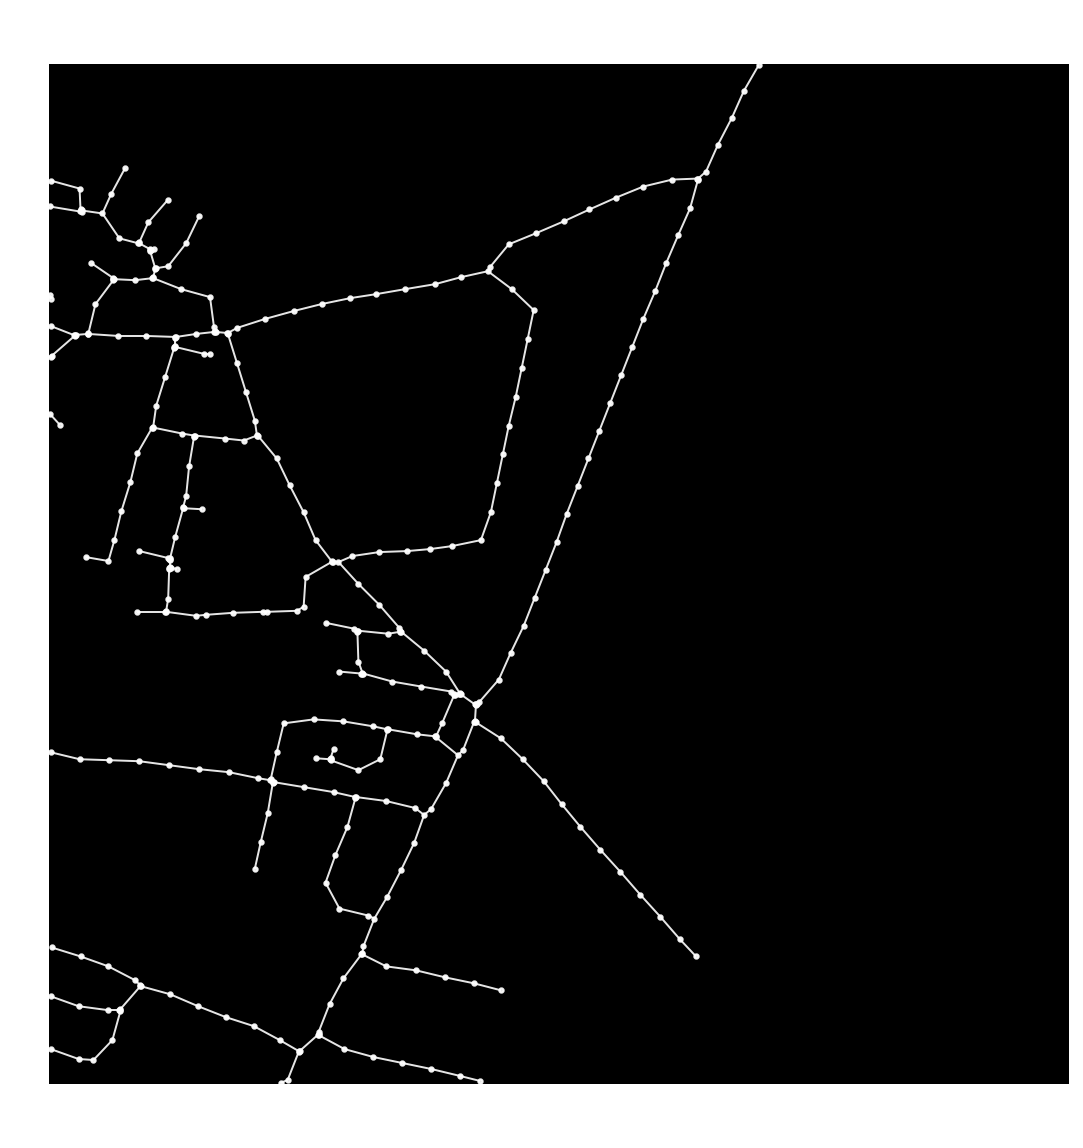

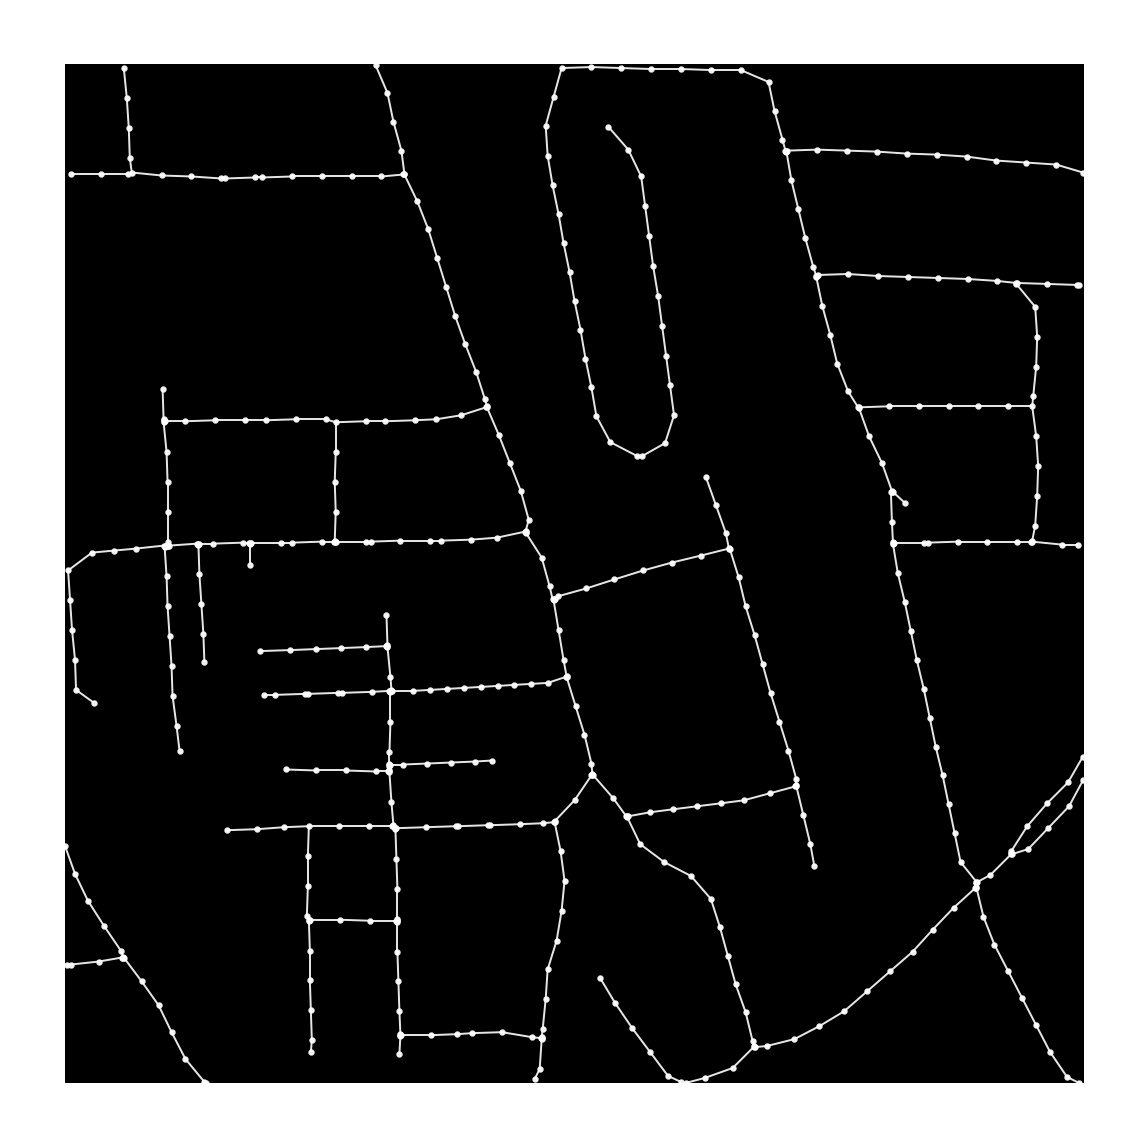

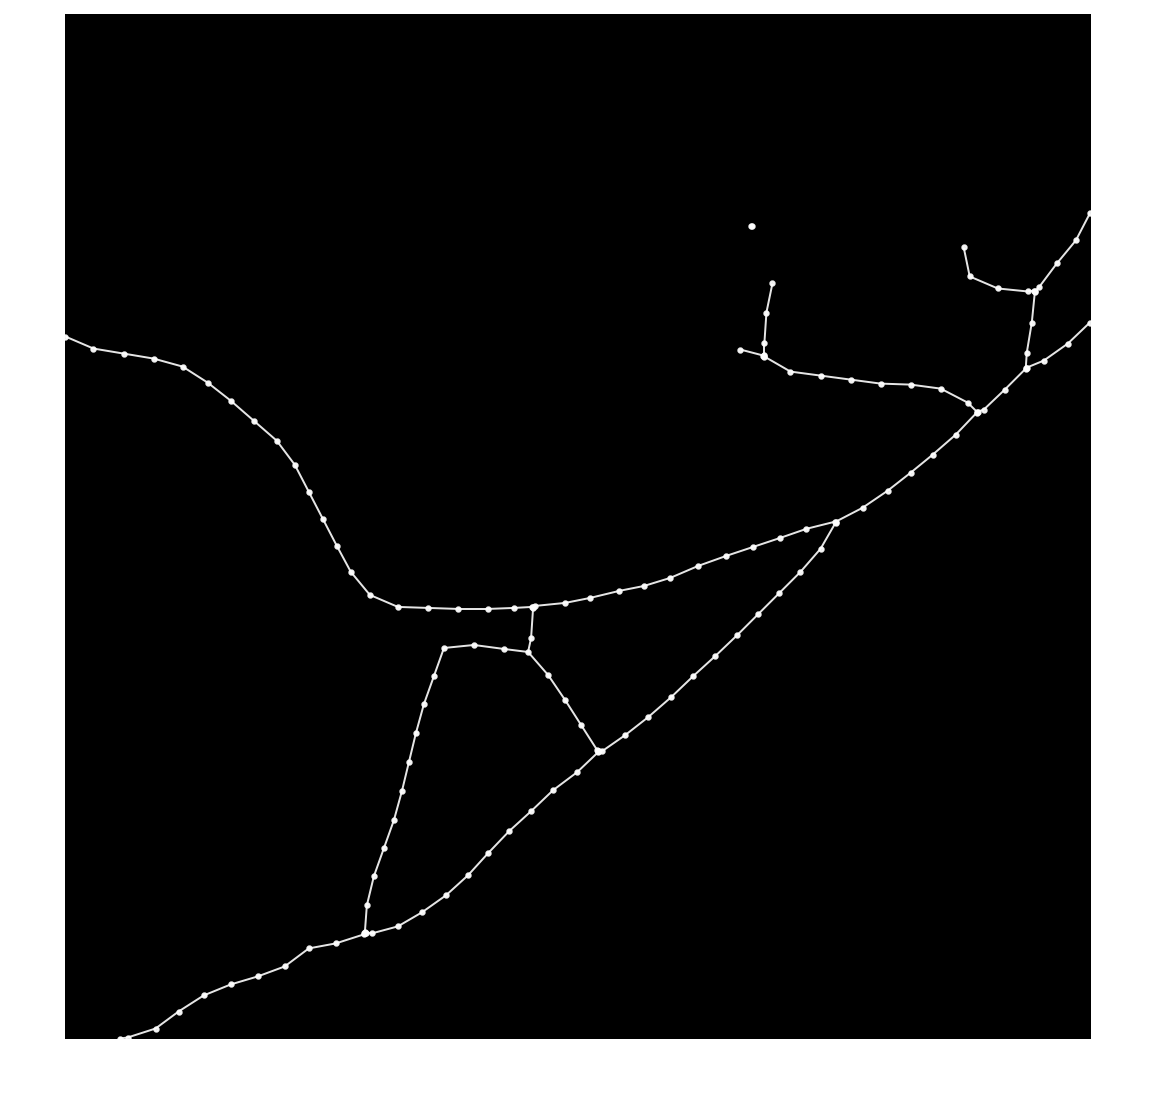

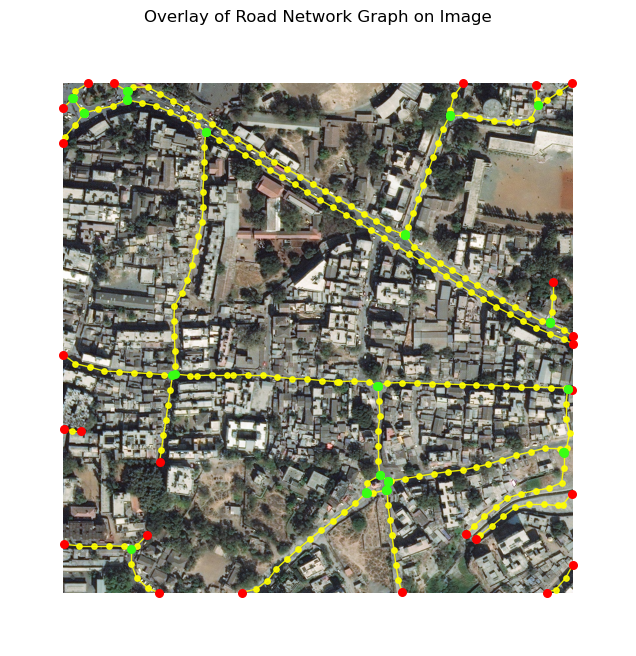

In [80]:
image = cv2.imread(os.path.join(orig_train_dir, random_image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_road_network_overlay(image, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=15)

In [111]:
random_mask = '992526_mask.png'
random_image = random_mask.replace('_mask.png', '_sat.jpg')

# read road network mask as greyscale
mask = cv2.imread(os.path.join(orig_train_dir, random_mask), 0)
graph = create_road_network_graph(mask)
terminal_nodes, intersection_nodes = classify_road_segments(graph)

# Plot the Road Network Graph (before contraction) with Image Overlay
print('Graph size before contraction:', len(graph.nodes()))
graph = contracting_nodes(graph, min_distance=100)

# Plot the Road Network Graph
#plot_road_network_graph(graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=50)

# Plot the Road Network Graph (after contraction) with Image Overlay
print('Graph size after contraction:' , len(graph.nodes()))
plot_road_network_overlay(mask, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=10)

Graph size before contraction: 13774


Graph size before contraction: 11107


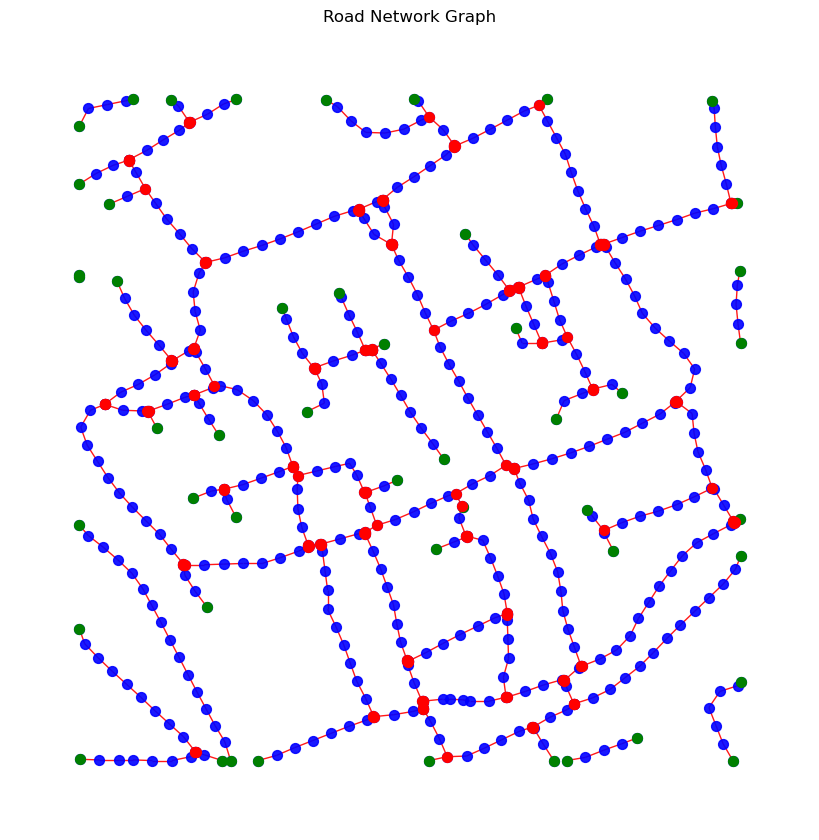

Graph size after contraction: 570


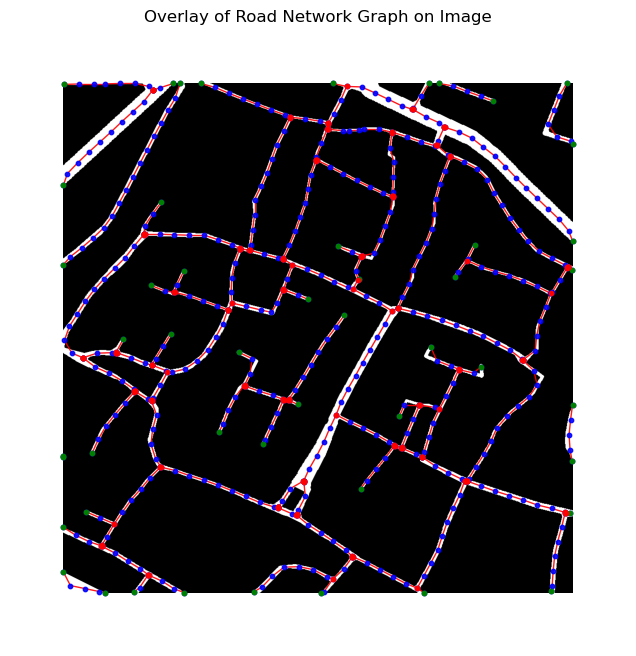

In [41]:
random_mask = '990851_mask.png'
random_image = random_mask.replace('_mask.png', '_sat.jpg')

# read road network mask as greyscale
mask = cv2.imread(os.path.join(orig_train_dir, random_mask), 0)
graph = create_road_network_graph(mask)
terminal_nodes, intersection_nodes = classify_road_segments(graph)

# Plot the Road Network Graph (before contraction) with Image Overlay
print('Graph size before contraction:', len(graph.nodes()))

graph = contracting_nodes(graph, min_distance=30)
# Plot the Road Network Graph (before contraction) with Image Overlay
print('Graph size after contraction:' , len(graph.nodes()))
plot_road_network_overlay(mask, graph, terminal_nodes, intersection_nodes, figsize=(8, 8), node_size=10)